# K-Means Clustering on the Boston Housing Dataset

## Overview

This Jupyter Notebook presents an implementation of the K-Means clustering algorithm applied to the Boston housing dataset. The goal of this analysis is to explore and identify underlying patterns in the data by grouping similar data points into clusters. 

## Dataset

The Boston housing dataset contains information collected by the U.S. Census Service concerning housing in the area of Boston, Massachusetts. It is a commonly used dataset for exploring machine learning algorithms. This analysis focuses on understanding the structure of Boston housing data by clustering neighborhoods based on various features, such as average number of rooms, property tax rates, pupil-teacher ratios, etc.

## Methodology

- **Data Preprocessing**: Load the Boston housing dataset, apply feature weights, normalize the data to have a mean of 0 and a standard deviation of 1.

- **Initialization**: Implement two centroid initialization methods—random initialization and the farthest point strategy—to explore their impact on the clustering outcomes.

- **Clustering**: Utilize the K-Means algorithm to group data points into clusters based on their similarity.

- **Evaluation** : Assess the quality of the clusters through iteration and adjust parameters as necessary to optimize the clustering outcome.

### This notebook is structured as follows:

- Introduction to the dataset and the clustering task.
- Preprocessing of the dataset, including feature weighting and normalization.
- Implementation of the K-Means clustering algorithm.
- Analysis of the clustering results and their implications.

In [20]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Loading and Preprocessing the data

data_path = 'boston.csv'
data = pd.read_csv(data_path)

In [3]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
# EDA

# Summary statistics
print("\nSummary Statistics:")
print(data.describe())

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())



Summary Statistics:
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std   


Visualizing the distribution of features...


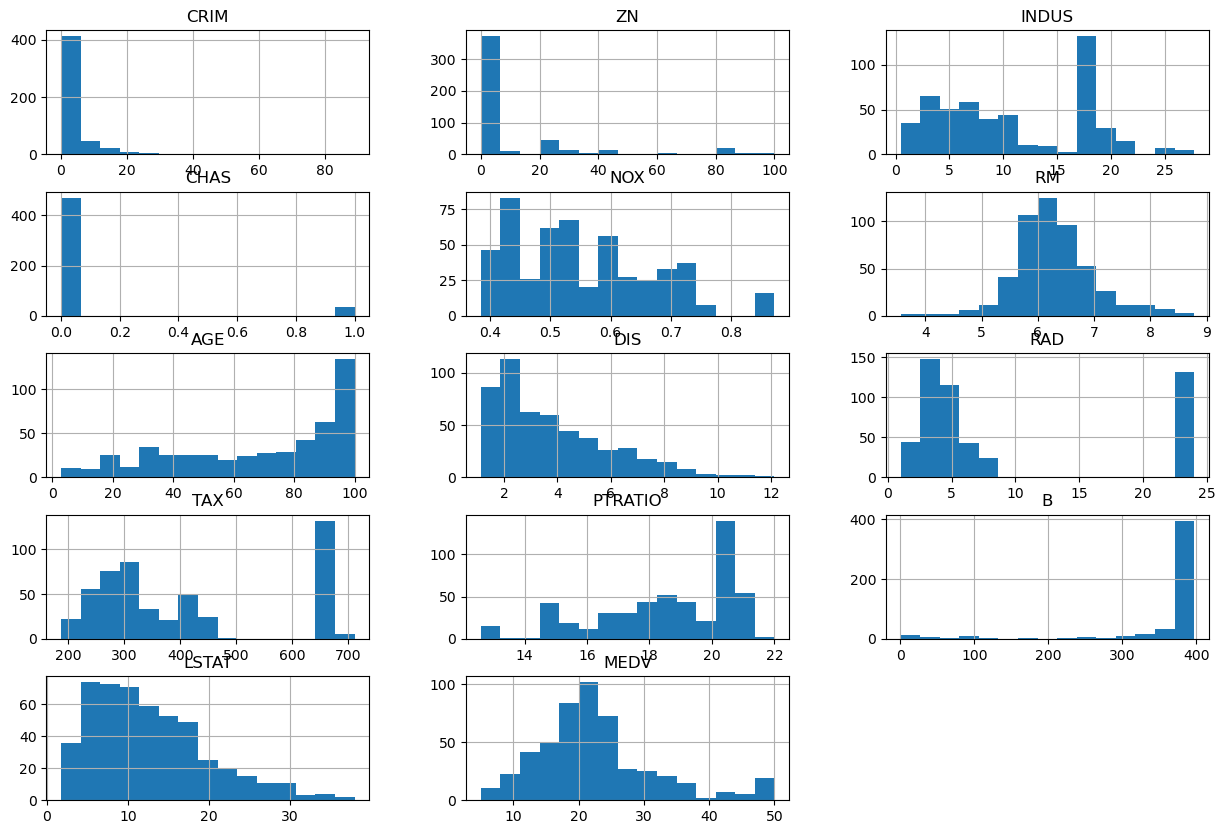

In [5]:
# Distribution of features
print("\nVisualizing the distribution of features...")
data.hist(bins=15, figsize=(15, 10), layout=(5, 3));


Correlation Matrix:


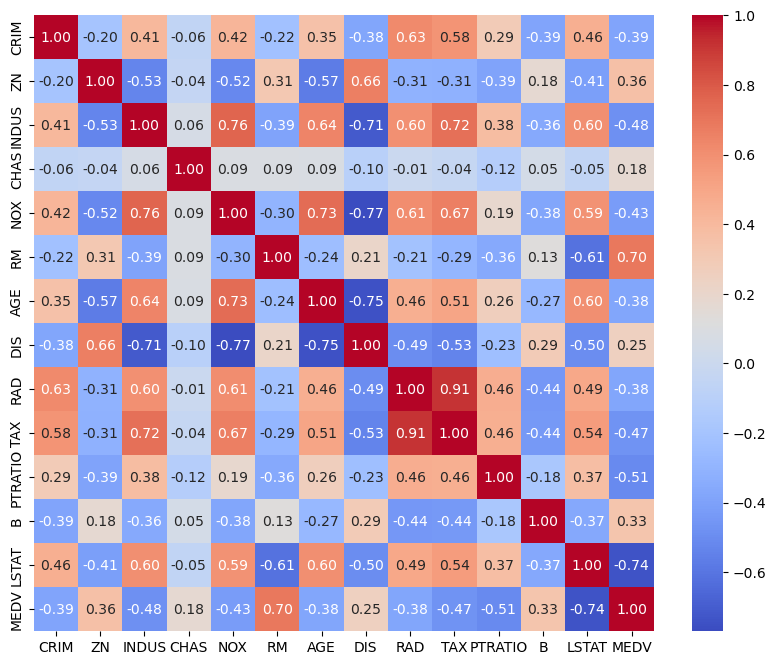

In [6]:
# Correlation matrix
print("\nCorrelation Matrix:")
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

### EDA Summary
#### Distributions:

- Crime Rate (CRIM): Right-skewed; low rates are most common.
- Zoning (ZN): Most areas are not zoned for large homes.
- Room Count (RM): Nearly normal; around 6 rooms per house.

#### Correlations:

- Industrial & Pollution (INDUS-NOX): Positively correlated.
- Distance & Pollution (DIS-NOX): Inversely related.
- Status & Value (LSTAT-MEDV): Lower economic status aligns with lower house values.
- Rooms & Value (RM-MEDV): More rooms generally mean higher house prices.

In [7]:
# Data Cleaning

# Apply logarithmic transformation to right-skewed features
skewed_features = ['CRIM', 'ZN', 'DIS', 'LSTAT']
data[skewed_features] = data[skewed_features].apply(lambda x: np.log1p(x))

# Identify and handle outliers
for feature in skewed_features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[feature] >= (Q1 - 1.5 * IQR)) & (data[feature] <= (Q3 + 1.5 * IQR))]

# Standardize the features
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [8]:
# Dimensionality reduction
high_corr_threshold = 0.7

# Identify features that are highly correlated
high_corrs = (corr_matrix.abs() > high_corr_threshold).sum() - 1  # Subtract 1 to ignore self-correlation
redundant_features = high_corrs[high_corrs > 0]

print(f"Number of features with correlation higher than {high_corr_threshold}: {len(redundant_features)}")
print(f"These features might be candidates for reduction: {redundant_features.index.tolist()}")

# The number of components for PCA could be the total features minus the redundant ones
n_components_choice = data_scaled.shape[1] - len(redundant_features)

print(f"Suggested number of components for PCA based on redundancy: {n_components_choice}")


Number of features with correlation higher than 0.7: 8
These features might be candidates for reduction: ['INDUS', 'NOX', 'AGE', 'DIS', 'RAD', 'TAX', 'LSTAT', 'MEDV']
Suggested number of components for PCA based on redundancy: 6


In [9]:
# PCA

# Apply PCA with 6 components
pca = PCA(n_components=6)
data_reduced = pca.fit_transform(data_scaled)

# Check the explained variance ratio of the 6 components
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

print("Explained variance by each component:", explained_variance)
print("Cumulative explained variance:", cumulative_explained_variance)


Explained variance by each component: [0.50020694 0.12294267 0.09385001 0.06205027 0.06117337 0.04799077]
Cumulative explained variance: [0.50020694 0.62314961 0.71699962 0.77904989 0.84022326 0.88821403]


In [10]:
data_reduced

array([[ 2.51297263,  0.38996726,  0.16982281,  1.10879127, -0.18509244,
        -0.56875487],
       [ 1.43032794, -0.61701303,  0.90498666, -0.02046182, -0.56083581,
         0.51192301],
       [ 2.55936372,  0.91610909,  0.25470371, -0.62973776, -1.11825026,
         0.83209536],
       ...,
       [ 0.4473829 ,  0.44001076,  1.09239585, -0.99717027, -1.48764598,
         0.96069672],
       [ 0.3240198 ,  0.09765477,  1.09433551, -0.89383987, -1.30245152,
         0.91699707],
       [-0.11852665, -1.16453162,  1.29225527, -0.62430357, -0.73912122,
         0.65117072]])

In [11]:
data_df = pd.DataFrame(data_reduced, columns=[f'PC{i+1}' for i in range(data_reduced.shape[1])])
data_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,2.512973,0.389967,0.169823,1.108791,-0.185092,-0.568755
1,1.430328,-0.617013,0.904987,-0.020462,-0.560836,0.511923
2,2.559364,0.916109,0.254704,-0.629738,-1.118250,0.832095
3,3.072003,0.443910,-0.197886,-1.049471,-0.899038,0.971472
4,2.833373,0.485608,-0.019283,-0.910866,-0.949578,0.945435


In [12]:
# K-means custom implementation

def initialize_centroids(data, k, method='random'):
    """
    Initialize centroids for K-means clustering.

    Parameters:
    - data (array-like): The dataset to cluster, where each row represents an observation.
    - k (int): The number of clusters to form.
    - method (str): The method for initializing centroids ('random' or 'farthest').

    Returns:
    - array: An array of 'k' centroids, each of which is a point in the dataset.
    """
    if method == 'random':
        return data.sample(n=k).values
    elif method == 'farthest':
        centroids = [data[np.random.randint(0, len(data))]]
        for _ in range(1, k):
            distances = np.min(cdist(data, centroids, 'euclidean'), axis=1)
            farthest = np.argmax(distances)
            centroids.append(data[farthest])
        return np.array(centroids)
    else:
        raise ValueError("Unsupported initialization method")

def assign_clusters(data, centroids):
    """
    Assign data points to the nearest centroid.

    Parameters:
    - data (array-like): The dataset where each row is a data point.
    - centroids (array-like): The current centroids.

    Returns:
    - array: An array of indices indicating the assigned cluster for each data point.
    """
    distances = cdist(data, centroids, 'euclidean')
    return np.argmin(distances, axis=1)

def update_centroids(data, labels, k):
    """
    Update centroid positions based on current cluster assignments.

    Parameters:
    - data (array-like): The dataset where each row is a data point.
    - labels (array-like): The cluster assignments for each data point.
    - k (int): The number of clusters.

    Returns:
    - array: An array containing the updated centroids.
    """
    new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

def kmeans(data, k, max_iter=100, tol=1e-4):
    """
    Perform K-means clustering on a dataset.

    Parameters:
    - data (array-like): The dataset to cluster, where each row represents an observation.
    - k (int): The number of clusters to form.
    - max_iter (int): The maximum number of iterations to run the algorithm.
    - tol (float): The tolerance to declare convergence (i.e., when centroids stop changing).

    Returns:
    - tuple: A tuple containing the final centroids and the cluster assignments for each data point.
    """
    centroids = initialize_centroids(data, k)
    for iteration in range(max_iter):
        labels = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, labels, k)
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
    return centroids, labels


In [16]:
centroids, labels = kmeans(data_df, k=3)

In [18]:
centroids

array([[-3.45024599,  0.38523603, -0.53145563, -0.00697126,  0.15399595,
        -0.2259827 ],
       [ 0.31354996, -0.63986854,  0.87101543, -0.12987334, -0.14792021,
         0.31226174],
       [ 2.83095135,  0.4181113 , -0.56258204,  0.16413396,  0.0362088 ,
        -0.16868602]])

In [19]:
labels

array([2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1,
       1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2,

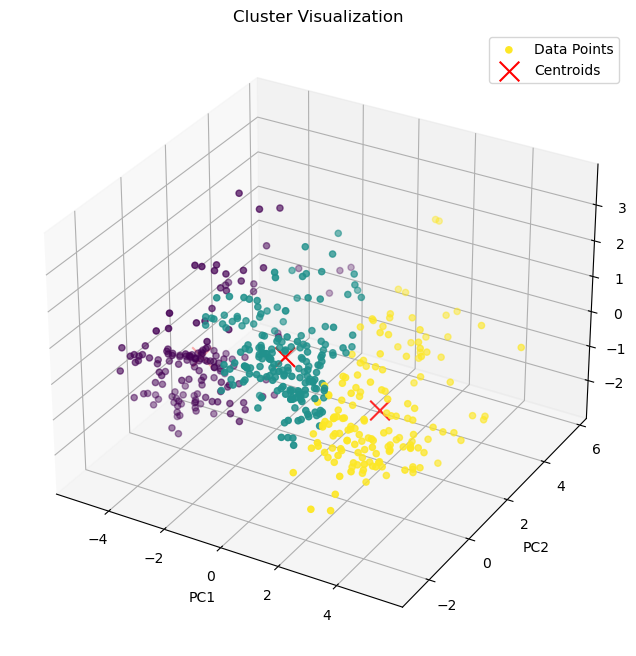

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to visualize clusters
def plot_clusters(data, labels, centroids):
    # Perform PCA for dimensionality reduction to 3 components
    pca = PCA(n_components=3)
    data_reduced = pca.fit_transform(data)

    # Plotting the clusters
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot for data points
    ax.scatter(data_reduced[:, 0], data_reduced[:, 1], data_reduced[:, 2], c=labels, cmap='viridis', label='Data Points')

    # Scatter plot for centroids
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', marker='x', s=200, label='Centroids')
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('Cluster Visualization')
    ax.legend()
    
    plt.show()

# Call the function to visualize clusters
plot_clusters(data_df.values, labels, centroids)
